In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-04-07 18:03:07--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2021-04-07 18:03:07 (5.23 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



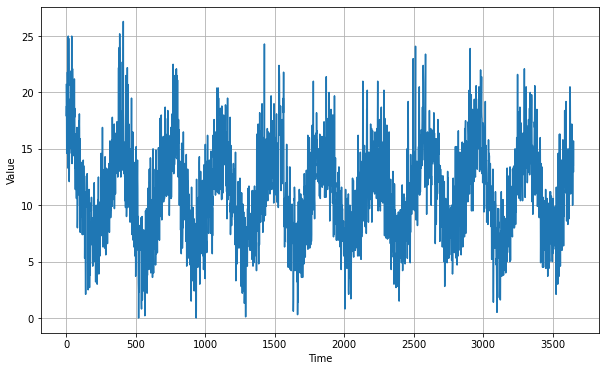

In [5]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
  reader = csv.reader(csvfile, delimiter = ',')
  next(reader)
  for i, row in enumerate(reader):
    temps.append(float(row[1]))
    time_step.append(i + 1)
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 2500
time_train = np.array(time_step[:split_time])
x_train = np.array(temps[:split_time])
time_valid = np.array(time_step[split_time:])
x_valid = np.array(temps[split_time:])

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 9s 89ms/step - loss: 10.5060 - mae: 11.0051
Epoch 2/100
10/10 [==============================] - 1s 73ms/step - loss: 10.5051 - mae: 11.0040
Epoch 3/100
10/10 [==============================] - 1s 73ms/step - loss: 10.4159 - mae: 10.9147
Epoch 4/100
10/10 [==============================] - 1s 71ms/step - loss: 10.3103 - mae: 10.8090
Epoch 5/100
10/10 [==============================] - 1s 70ms/step - loss: 10.2517 - mae: 10.7503
Epoch 6/100
10/10 [==============================] - 1s 71ms/step - loss: 10.2026 - mae: 10.7012
Epoch 7/100
10/10 [==============================] - 1s 74ms/step - loss: 10.2252 - mae: 10.7239
Epoch 8/100
10/10 [==============================] - 1s 72ms/step - loss: 10.1115 - mae: 10.6101
Epoch 9/100
10/10 [==============================] - 1s 75ms/step - loss: 10.0127 - mae: 10.5113
Epoch 10/100
10/10 [=====

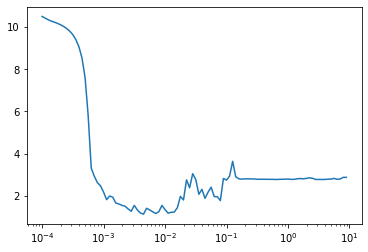

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.show()

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, 
                             shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(16, activation="relu"),
  tf.keras.layers.Dense(1)
])


optimizer = tf.keras.optimizers.SGD(lr=3e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs = 100)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/100
10/10 [==============================] - 7s 87ms/step - loss: 10.3936 - mae: 10.8925
Epoch 2/100
10/10 [==============================] - 1s 86ms/step - loss: 9.8293 - mae: 10.3278
Epoch 3/100
10/10 [==============================] - 1s 83ms/step - loss: 7.5134 - mae: 8.0076
Epoch 4/100
10/10 [==============================] - 1s 84ms/step - loss: 3.4162 - mae: 3.8907
Epoch 5/100
10/10 [==============================] - 1s 86ms/step - loss: 3.0214 - mae: 3.4911
Epoch 6/100
10/10 [==============================] - 1s 84ms/step - loss: 2.5879 - mae: 3.0527
Epoch 7/100
10/10 [==============================] - 1s 83ms/step - loss: 2.1492 - mae: 2.6055
Epoch 8/100
10/10 [==============================] - 1s 84ms/step - loss: 2.5210 - mae: 2.9858
Epoch 9/100
10/10 [==============================] - 1s 83ms/step - loss: 1.8501 - mae: 2.3006
Epoch 10/100
10/10 [==============================] - 1s 85ms/step - loss: 1.6518 - mae: 2.1005
Epoch 11/100
10/10 [==========================

In [12]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

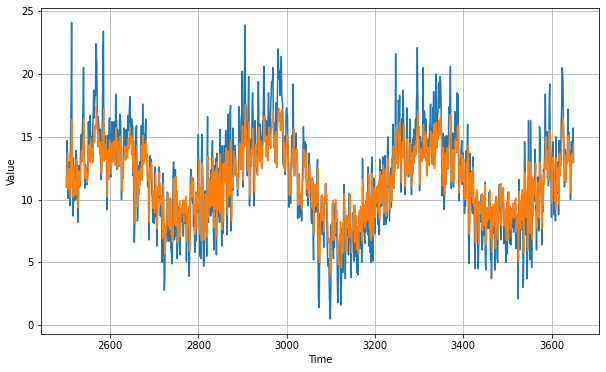

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.9053471

In [15]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.81115   10.996913  12.557243  ... 13.1721325 13.082519  14.404197 ]
